<a href="https://colab.research.google.com/github/imran9891/TensorFlow/blob/main/10_time_series_forecasing_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series forecasting with TensorFlow + Milestone Project 3: BitPredict

Let's write some TensorFlow code to predict the price of Bitcoin based on the historical price of Bitcoin.

**Note:** This is not a financial advice.

In [1]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-70380fc8-bd66-50d8-d6c0-165f9b85ead8)


## Get data

We're going to be using the historical price data of Bitcoin to try and predict the future price of Bitcoin, we downloaded the data from here: https://www.coindesk.com/price/bitcoin/

### Importing time series data with pandas

In [2]:
# Import with pandas
import pandas as pd
# Let's read in our Bitcoin data and parse the dates
df = pd.read_csv("drive/MyDrive/Bitcoin/BTC.csv",parse_dates=["Date"],index_col=["Date"])
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2014-11-03,BTC,331.60083,325.22633,333.75983,319.04350
2014-11-04,BTC,324.71833,331.60083,332.75133,323.06333
2014-11-05,BTC,332.45666,324.71833,335.81166,320.93333
2014-11-06,BTC,336.58500,332.45666,341.49000,328.56166
2014-11-07,BTC,346.77500,336.58500,351.57500,336.02833


In [3]:
df.tail()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2021-10-21,BTC,65972.863130,64281.342631,66915.500437,63603.165032
2021-10-22,BTC,62603.575070,65986.244921,66635.466408,62290.325376
2021-10-23,BTC,60689.238265,62192.232903,63717.168947,60033.928038
2021-10-24,BTC,61124.347126,60692.609117,61733.585205,59694.050434
2021-10-25,BTC,60936.150851,61304.790355,61490.095150,59553.027885


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2548 entries, 2014-11-03 to 2021-10-25
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2548 non-null   object 
 1   Closing Price (USD)  2548 non-null   float64
 2   24h Open (USD)       2548 non-null   float64
 3   24h High (USD)       2548 non-null   float64
 4   24h Low (USD)        2548 non-null   float64
dtypes: float64(4), object(1)
memory usage: 119.4+ KB


In [5]:
# How many samples do we have?
len(df)

2548

We've collected the historical prices of Bitcoin for the past ~7 years but thers's only 2548 samples.

Typically deep learning models usually be like lots and lots of samples (from thousands to tens of thousands to millions).

A smaller number of samples is something you'll often run into with time-series data problems.

**Note:** The **seasonality** of a time series dataset is referred as the number of samples per year. So for our Bitcoin data, it has a seasonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year.

## Time series patterns

* **Trend:** Time series has a clear long-term increase or decrease (may or may not be linear)

* **Seasonal:** Time series affected by seasonal factors such as time of year (e.g. increased sales towards the end of year) or day of week.

* **Cyclic:** Time series shows rises and falls over an unfixed period, these tend to be longer/more variable than seasonal patterns.

* **Univariate:** Only one variable (e.g. using the price of the Bitcoin to predict the price of Bitcoin).

* **Multivariate:** More than one variable (e.g. using the price of Bitcoin as well as the block reward size to predict the price of Bitcoin).

In [6]:
## Visualize only Date and Closing Price (USD)
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)":"Price"})
bitcoin_prices.head()

,Price
Date,
2014-11-03,331.60083
2014-11-04,324.71833
2014-11-05,332.45666
2014-11-06,336.58500
2014-11-07,346.77500


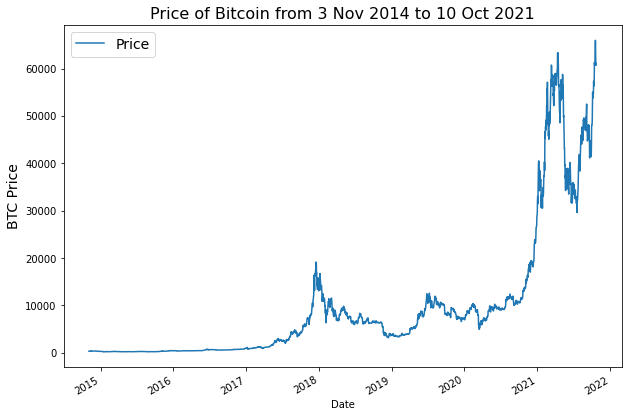

In [7]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price",fontsize=14)
plt.title("Price of Bitcoin from 3 Nov 2014 to 10 Oct 2021",fontsize=16)
plt.legend(fontsize=14);

## Importing time series data with Python's CSV module

In [9]:
import csv
with open("drive/MyDrive/Bitcoin/BTC.csv","r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  for line in csv_reader:
    print(line)

['Currency', 'Date', 'Closing Price (USD)', '24h Open (USD)', '24h High (USD)', '24h Low (USD)']
['BTC', '2014-11-03', '331.60083', '325.22633', '333.75983', '319.0435']
['BTC', '2014-11-04', '324.71833', '331.60083', '332.75133', '323.06333']
['BTC', '2014-11-05', '332.45666', '324.71833', '335.81166', '320.93333']
['BTC', '2014-11-06', '336.585', '332.45666', '341.49', '328.56166']
['BTC', '2014-11-07', '346.775', '336.585', '351.575', '336.02833']
['BTC', '2014-11-08', '344.81166', '346.775', '351.295', '339.86']
['BTC', '2014-11-09', '343.065', '344.81166', '345.625', '340.63']
['BTC', '2014-11-10', '358.50166', '343.065', '363.85333', '342.325']
['BTC', '2014-11-11', '368.07666', '358.50166', '374.71166', '357.98']
['BTC', '2014-11-12', '376.99666', '368.07666', '380.52', '360.49166']
['BTC', '2014-11-13', '442.10666', '376.99666', '442.37166', '376.98666']
['BTC', '2014-11-14', '389.00333', '442.10666', '458.05166', '385.675']
['BTC', '2014-11-15', '394.92666', '389.00333', '412.

In [11]:
# Importing and formatting historical Bitcoin data with Python
import datetime as dt
timesteps = []
btc_price = []
with open("drive/MyDrive/Bitcoin/BTC.csv","r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (this gets rid of the column titles, the header part)
  for line in csv_reader:
    timesteps.append(dt.datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings)
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10],btc_price[:10]

([datetime.datetime(2014, 11, 3, 0, 0),
  datetime.datetime(2014, 11, 4, 0, 0),
  datetime.datetime(2014, 11, 5, 0, 0),
  datetime.datetime(2014, 11, 6, 0, 0),
  datetime.datetime(2014, 11, 7, 0, 0),
  datetime.datetime(2014, 11, 8, 0, 0),
  datetime.datetime(2014, 11, 9, 0, 0),
  datetime.datetime(2014, 11, 10, 0, 0),
  datetime.datetime(2014, 11, 11, 0, 0),
  datetime.datetime(2014, 11, 12, 0, 0)],
 [331.60083,
  324.71833,
  332.45666,
  336.585,
  346.775,
  344.81166,
  343.065,
  358.50166,
  368.07666,
  376.99666])

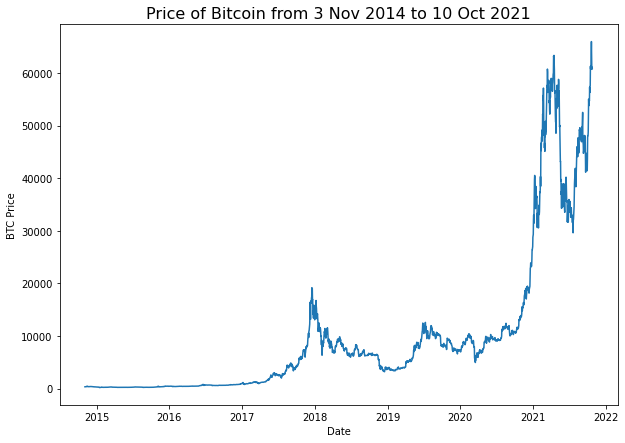

In [12]:
# Plot from CSV
plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 3 Nov 2014 to 10 Oct 2021",fontsize=16)
plt.xlabel("Date");

## Format data part 1: Create train and test sets of our time series data

### Creating train and test sets with time series data (the wrong way)

In [13]:
bitcoin_prices[:5]

,Price
Date,
2014-11-03,331.60083
2014-11-04,324.71833
2014-11-05,332.45666
2014-11-06,336.58500
2014-11-07,346.77500


In [14]:
# Get bitcoin date and price array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices.Price.to_numpy()

timesteps[:10], prices[:10]

(array(['2014-11-03T00:00:00.000000000', '2014-11-04T00:00:00.000000000',
        '2014-11-05T00:00:00.000000000', '2014-11-06T00:00:00.000000000',
        '2014-11-07T00:00:00.000000000', '2014-11-08T00:00:00.000000000',
        '2014-11-09T00:00:00.000000000', '2014-11-10T00:00:00.000000000',
        '2014-11-11T00:00:00.000000000', '2014-11-12T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([331.60083, 324.71833, 332.45666, 336.585  , 346.775  , 344.81166,
        343.065  , 358.50166, 368.07666, 376.99666]))

In [15]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(timesteps,prices,test_size=0.2,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((2038,), (510,), (2038,), (510,))

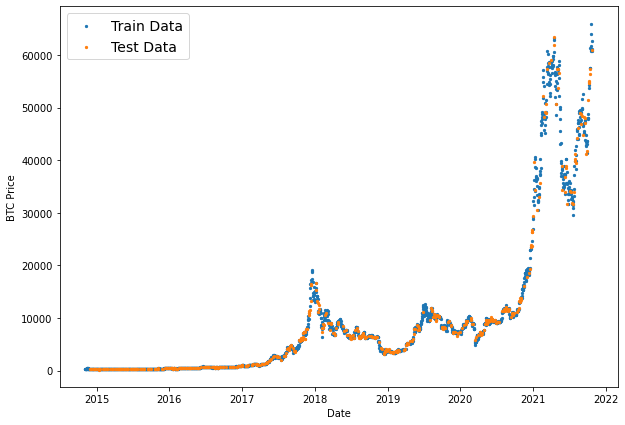

In [16]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10,7))
plt.scatter(X_train,y_train,s=5,label="Train Data")
plt.scatter(X_test,y_test,s=5,label="Test Data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14);

## Create train & test sets for time series (the right way)

In [17]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test -we can change these values as needed

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

X_train.shape,X_test.shape,y_train.shape,y_test.shape

((2038,), (510,), (2038,), (510,))

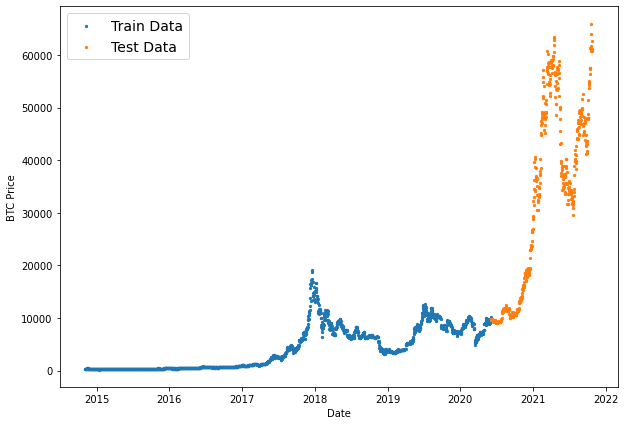

In [18]:
# Let's plot right train and test splits
plt.figure(figsize=(10,7))
plt.scatter(X_train,y_train,s=5,label="Train Data")
plt.scatter(X_test,y_test,s=5,label="Test Data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14);

## Create a plotting function

Typing plotting code is tedious, let's functionize it.

In [19]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots timesteps (a series of points in time) against values (a series of values accross timesteps)

  Parameters
  ----------
  timesteps: array of timestep values
  values: array of values accross time
  format: style of plot, default "."
  start: where to start the plot (setting a value will index from start of timesteps & values)
  end: where to end the plot (similar to staet but for the end)
  label: label to show on plot about values, default None
  """

  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

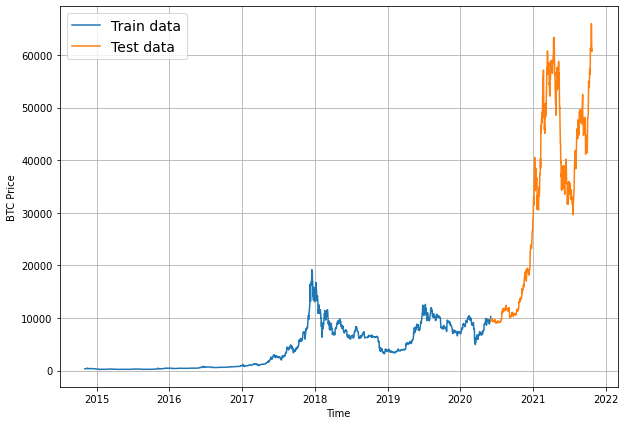

In [20]:
# Test out plotting function
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train,values=y_train,label="Train data",format="-")
plot_time_series(timesteps=X_test,values=y_test,label="Test data",format="-")

## Modelling Experiments

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

Terms to be familiar with:
* **Horizon:** number of timesteps into the future we're going to predict
* **Window size:** number of timesteps we're going to use to predict horizon

* Model 0: Naive model (baseline)
* Model 1: Dense model, window = 7, horizon = 1
* Model 2: Same as model 1, window = 30, horizon = 1
* Model 3: Same as model 1, window = 30, horizon = 7
* Model 4: Conv1D
* Model 5: LSTM
* Model 6: Same as model 1 (but with multivariate data)
* Model 7: N-BEATS algorithm
* Model 8: Ensemble (multiple models stacked together)
* Model 9: Future prediction model
* Model 10: Same as model 1 (but with turkey data introduced)

## Model 0: Naive forecast (baseline)

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:

> The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) ~this is for a horizon of 1.

In [21]:
y_test[:10], y_test[-10:]

(array([9516.13544309, 9667.06075426, 9811.3670946 , 9659.66129819,
        9677.05099451, 9737.45855879, 9791.92789977, 9786.14202048,
        9874.96704752, 9260.83264099]),
 array([61273.80527589, 60744.98493804, 60965.46543362, 61707.48131182,
        63901.07308021, 65972.86312976, 62603.57506991, 60689.23826486,
        61124.34712562, 60936.15085142]))

In [22]:
# Create a naive forecast
naive_forecast = y_test[:-1]
naive_forecast[:10], naive_forecast[-10:]

(array([9516.13544309, 9667.06075426, 9811.3670946 , 9659.66129819,
        9677.05099451, 9737.45855879, 9791.92789977, 9786.14202048,
        9874.96704752, 9260.83264099]),
 array([57559.06444208, 61273.80527589, 60744.98493804, 60965.46543362,
        61707.48131182, 63901.07308021, 65972.86312976, 62603.57506991,
        60689.23826486, 61124.34712562]))

In [23]:
nf = pd.DataFrame({"original":y_test[1:],"Preds":y_test[:-1]})
nf.head()

,original,Preds
0,9667.060754,9516.135443
1,9811.367095,9667.060754
2,9659.661298,9811.367095
3,9677.050995,9659.661298
4,9737.458559,9677.050995


In [24]:
nf.tail()

,original,Preds
504,65972.863130,63901.073080
505,62603.575070,65972.863130
506,60689.238265,62603.575070
507,61124.347126,60689.238265
508,60936.150851,61124.347126


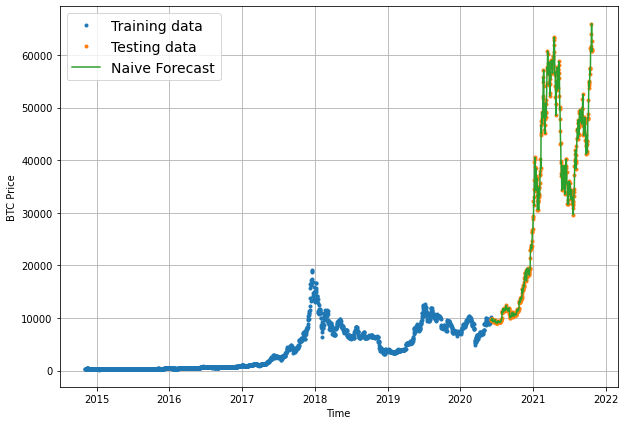

In [25]:
# Plot naive forecast
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train,values=y_train,label="Training data")
plot_time_series(timesteps=X_test,values=y_test,label="Testing data")
plot_time_series(timesteps=X_test[1:],values=naive_forecast,format="-",label="Naive Forecast")

## Evaluating a time series model 

Let's look into some evaluation metrics for time series forecasting.

What are we doing?

We're predicting a number, so that means we have a form of a regression problem.

Because we're working on a regression problem, we'll need some regression like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - Mean Absolute Error ~ as a great starter metric for any regression problem
* MSE - Mean Squared Error ~ when larger errors are more significant than smaller errors
* RMSE - Root Mean Squared Error ~ similar to MSE but as interpretable as MAE (RMSE is in same units as target)
* MAPE - (Symmetric) Mean Absolute Percentage Error (MAPE/sMAPE) ~ Recommend not to use by Hyndman & Koehler
* MASE - Mean Absolute Scaled Error ~ **A scaled error is > 1 if the forecast is worse than the naive and < 1 if the forecast is better than the naive.**

For all the above metrics, **lower is better**, for example, an MAE of 0 is better than an MAE of 100.

The main thing we're evaluating here is: **how do our model's forecasts (y_pred) compare against the actual values (y_true or ground truth values)?**

In [26]:
import tensorflow as tf

In [27]:
# MASE implementation
def mean_absolute_scaled_error(y_true,y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_pred-y_true))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shift of 1)

  return mae/mae_naive_no_season

In [28]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9983569431950776

* Numpy uses generally float64 dtype

In [29]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds (y_true,y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true,y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true,y_pred)
  rmse = mse**0.5
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred)
  mase = mean_absolute_scaled_error(y_true,y_pred)

  return {"mae":mae.numpy(),
          "mse":mse.numpy(),
          "rmse":rmse.numpy(),
          "mape":mape.numpy(),
          "mase":mase.numpy()}

In [30]:
naive_results = evaluate_preds(y_true=y_test[1:],y_pred=naive_forecast)
naive_results

{'mae': 920.5374,
 'mape': 2.6014113,
 'mase': 0.99835706,
 'mse': 2046720.0,
 'rmse': 1430.6362}

In [31]:
tf.reduce_mean(y_test)

<tf.Tensor: shape=(), dtype=float64, numpy=32022.8806058388>

In [32]:
tf.reduce_min(y_test), tf.reduce_max(y_test)

(<tf.Tensor: shape=(), dtype=float64, numpy=9022.1537680028>,
 <tf.Tensor: shape=(), dtype=float64, numpy=65972.8631297649>)

## Other models we can use for baselines and for actual forecasts

In this notebook, we're focused on TensorFlow and deep learning models.

However, there are plenty of other styles of time series forecasting models we may want to experiment with: https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/


## Format Data Part 2: Windowing our dataset

Why do we window?

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0,1,2,3,4,5,6] -> [7]
[1,2,3,4,5,6,7] -> [8]
[2,3,4,5,6,7,8] -> [9]
```

In [33]:
btc_price[:7], btc_price[7]

([331.60083, 324.71833, 332.45666, 336.585, 346.775, 344.81166, 343.065],
 358.50166)

In [34]:
# What we want to do with our bitcoin data
print(f"We want to use: {btc_price[:7]} to predict this: {btc_price[7]}")

We want to use: [331.60083, 324.71833, 332.45666, 336.585, 346.775, 344.81166, 343.065] to predict this: 358.50166


In [35]:
# Let's setup global variables for window and horizon size
HORIZON = 1 # predict next one day
WINDOW_SIZE = 7 # use the past week of Bitcoin data to make the prediction

In [36]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon = 1
  Input: [0,1,2,3,4,5,6,7] -> Output: ([0,1,2,3,4,5,6],[7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [37]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8),axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


We've got a way to label our windowed data.

However, this only works on a small scale.

We need a way to do the above accross our entire time series.

We could do this with Python for loops, however, for large time series, that'd be quite slow.

To speed things up, we'll leverage Numpy's array indexing.

Our function will:
1. Create a window step of specific window size (e.g. [0, 1, 2, 3, 4, 5, 6])
2. Use Numpy indexing to create a 2D array of multiple window steps, for example:

```
[[0, 1, 2, 3, 4, 5, 6]
[1, 2, 3, 4, 5, 6, 7]
[2, 3, 4, 5, 6, 7, 8]
---------------------]
```
3. Uses the 2D array of multiple window steps (from 2.) to index on a target series (e.g. the historical price of Bitcoin)
4. Uses our `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon.

> **Resources:** The function we're about to create has been adapted from the following article:
https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

In [40]:
import numpy as np
# Create function to view Numpy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON): 
  """
  Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
  """
  # 1. Create a window of specific window size (add the horizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size+horizon),axis=0)
  
  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)),axis=0).T # create 2D array of windows of size window_size
  
  # 3. Index on the target array (a time series with 2D array of multiple timesteps)
  windowed_array = x[window_indexes]
  
  # 4. Get the labelled windows 
  windows, labels = get_labelled_windows(x=windowed_array,horizon=horizon)
  return windows,labels

In [41]:
full_windows, full_labels = make_windows(prices)
len(full_windows), len(full_labels)

(2541, 2541)

In [42]:
# View the first 3 windows and horizon
for i in range(3):
  print(f"Window: {full_windows[i]} -> Horizon: {full_labels[i]}")

Window: [331.60083 324.71833 332.45666 336.585   346.775   344.81166 343.065  ] -> Horizon: [358.50166]
Window: [324.71833 332.45666 336.585   346.775   344.81166 343.065   358.50166] -> Horizon: [368.07666]
Window: [332.45666 336.585   346.775   344.81166 343.065   358.50166 368.07666] -> Horizon: [376.99666]


In [43]:
# View the last 3 windows and horizon
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Horizon: {full_labels[i-3]}")

Window: [61273.80527589 60744.98493804 60965.46543362 61707.48131182
 63901.07308021 65972.86312976 62603.57506991] -> Horizon: [60689.23826486]
Window: [60744.98493804 60965.46543362 61707.48131182 63901.07308021
 65972.86312976 62603.57506991 60689.23826486] -> Horizon: [61124.34712562]
Window: [60965.46543362 61707.48131182 63901.07308021 65972.86312976
 62603.57506991 60689.23826486 61124.34712562] -> Horizon: [60936.15085142]


## Turning windows into training and test sets

In [44]:
# Make the train test splits
def make_train_test_splits(windows,labels,test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits
  """
  split_size = int(len(windows) * (1-test_split)) # default to 80% train and 20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [45]:
# Splitting the windows and labels
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2032, 509, 2032, 509)

In [46]:
train_windows[:5], train_labels[:5]

(array([[331.60083, 324.71833, 332.45666, 336.585  , 346.775  , 344.81166,
         343.065  ],
        [324.71833, 332.45666, 336.585  , 346.775  , 344.81166, 343.065  ,
         358.50166],
        [332.45666, 336.585  , 346.775  , 344.81166, 343.065  , 358.50166,
         368.07666],
        [336.585  , 346.775  , 344.81166, 343.065  , 358.50166, 368.07666,
         376.99666],
        [346.775  , 344.81166, 343.065  , 358.50166, 368.07666, 376.99666,
         442.10666]]), array([[358.50166],
        [368.07666],
        [376.99666],
        [442.10666],
        [389.00333]]))

In [47]:
# Check to see if train labels are the same (before and after window split)
np.array_equal(np.squeeze(train_labels[:-HORIZON]),y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint callback

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.

More specifically, we want to compare each of our model's best performance against the other model's best performances.

For example, if our model performs the best on epoch 55 (but we're training for 100 epochs), we want to load and evaluate the model saved on epoch 55.



In [48]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path,model_name),
                                            save_best_only=True)

## Model 1: Dense model (window=7, horizon=1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimizer and MAE loss function
* Batch size of 128 (previously we have used 32)
* 100 epochs

* **Hyperparameters:** values a machine learning practitioner can adjust themselves
* **Parameters:** values a model learns on its own

In [49]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct the model
model_1 = Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON,activation="linear")
],name="model_1_dense")

# Compile the model
model_1.compile(
    loss = tf.keras.losses.MeanAbsoluteError(),
    optimizer = Adam(),
    metrics = ["mae","mse"]
)

# Fit the model
history_model_1 = model_1.fit(x=train_windows,y=train_labels,
                              epochs=100,verbose=1,batch_size=128,
                              validation_data=(test_windows,test_labels),
                              callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
16/16 [==============================] - 3s 16ms/step - loss: 1054.7510 - mae: 1054.7510 - mse: 3316919.0000 - val_loss: 4183.1777 - val_mae: 4183.1777 - val_mse: 29540600.0000
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 375.0544 - mae: 375.0544 - mse: 455478.3438 - val_loss: 2167.9478 - val_mae: 2167.9478 - val_mse: 8892903.0000
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 249.9380 - mae: 249.9380 - mse: 245340.3906 - val_loss: 1791.4172 - val_mae: 1791.4172 - val_mse: 6553889.5000
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
Epoch 4/100
16/16 [==============================] - 0s 5ms/step - loss: 227.3227 - mae: 227.3227 - mse: 211430.7031 - val_loss: 1653.7842 - val_mae: 1653.7841 - val_mse: 5827853.0000
INFO:tensorflow:Assets written to: mo

In [50]:
# Evaluate model on the test data
model_1.evaluate(test_windows, test_labels)

16/16 [==============================] - 0s 3ms/step - loss: 965.5067 - mae: 965.5067 - mse: 2176198.0000


[965.5067138671875, 965.5067138671875, 2176198.0]

In [51]:
# Load in saved best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1.evaluate(test_windows,test_labels)

16/16 [==============================] - 0s 3ms/step - loss: 931.1143 - mae: 931.1143 - mse: 2108536.0000


[931.1143188476562, 931.1143188476562, 2108536.0]

## Making forecasts with a model (on the test dataset)

To make "forecasts" on the test dataset (note: these won't be actual forecasts, they're only psuedo forecasts because actual forecasts are into the future), let's write a function to:

1. Take in a trained model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the predictions


In [52]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input data
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [53]:
# Make predictions using model_1 on the test dataset
model_1_preds = make_preds(model_1, test_windows)
model_1_preds[:10], len(model_1_preds)

(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([9705.412 , 9681.258 , 9778.2705, 9766.946 , 9673.809 , 9746.938 ,
        9823.5625, 9814.906 , 9888.986 , 9402.475 ], dtype=float32)>, 509)

In [54]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),y_pred=model_1_preds)
model_1_results

{'mae': 931.1143,
 'mape': 2.6278691,
 'mase': 1.0098281,
 'mse': 2108535.8,
 'rmse': 1452.0798}

In [55]:
naive_results

{'mae': 920.5374,
 'mape': 2.6014113,
 'mase': 0.99835706,
 'mse': 2046720.0,
 'rmse': 1430.6362}

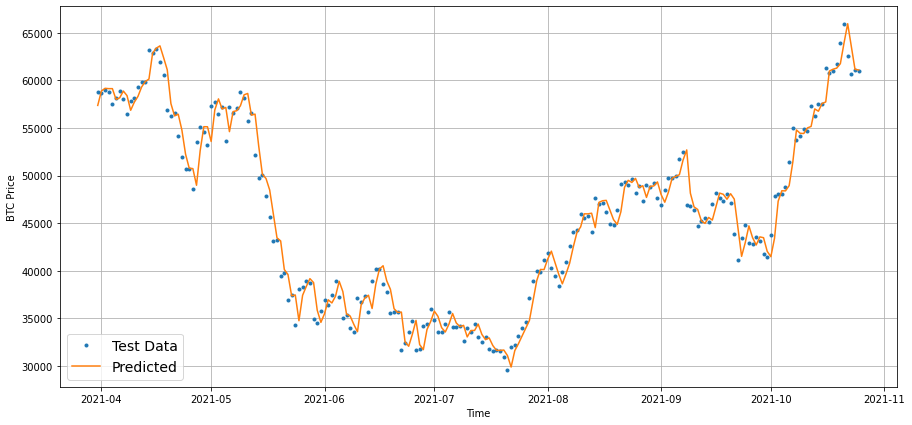

In [56]:
# Let's plot model_1 predictions
offset=300
plt.figure(figsize=(15,7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:,0],
                 start=offset,
                 format=".",
                 label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_1_preds,
                 format="-",
                 start=offset,
                 label="Predicted")

## Model 2: Similar to Model 1 (window size=30 & horizon=1)

In [58]:
# What we want to do with our bitcoin data
print(f"We want to use: {btc_price[:30]} to predict this\n: {btc_price[30]}")

We want to use: [331.60083, 324.71833, 332.45666, 336.585, 346.775, 344.81166, 343.065, 358.50166, 368.07666, 376.99666, 442.10666, 389.00333, 394.92666, 377.08, 400.47166, 384.93, 375.83333, 376.16, 348.565, 352.42, 356.8, 367.83, 381.20666, 375.498, 372.819, 368.983, 375.44, 376.851, 376.13218, 377.862] to predict this
: 382.452


In [59]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(31),axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29] -> Label: 30


In [60]:
# Make windows data with horizon
full_windows_30, full_labels_30 = make_windows(x=prices,window_size=30,horizon=1)
full_windows_30[0], full_labels_30[0]

(array([331.60083, 324.71833, 332.45666, 336.585  , 346.775  , 344.81166,
        343.065  , 358.50166, 368.07666, 376.99666, 442.10666, 389.00333,
        394.92666, 377.08   , 400.47166, 384.93   , 375.83333, 376.16   ,
        348.565  , 352.42   , 356.8    , 367.83   , 381.20666, 375.498  ,
        372.819  , 368.983  , 375.44   , 376.851  , 376.13218, 377.862  ]),
 array([382.452]))

In [61]:
# Splitting into train and test windows
train_windows_30,test_windows_30,train_labels_30,test_labels_30 =  make_train_test_splits(windows=full_windows_30,
                                                                                          labels=full_labels_30,
                                                                                          test_split=0.2)
len(train_windows_30),len(test_windows_30),len(train_labels_30),len(test_labels_30)

(2014, 504, 2014, 504)

In [62]:
# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct the model
model_2 = Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON,activation="linear")
],name="model_2_dense")

# Compile the model
model_2.compile(
    loss = tf.keras.losses.MeanAbsoluteError(),
    optimizer = Adam(),
    metrics = ["mae","mse"]
)

# Fit the model
history_model_2 = model_2.fit(x=train_windows_30,y=train_labels_30,
                              epochs=100,verbose=1,batch_size=128,
                              validation_data=(test_windows_30,test_labels_30),
                              callbacks=[create_model_checkpoint(model_name=model_2.name)])

Epoch 1/100
16/16 [==============================] - 1s 14ms/step - loss: 1382.2308 - mae: 1382.2308 - mse: 5839278.5000 - val_loss: 7574.1670 - val_mae: 7574.1670 - val_mse: 89304824.0000
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 596.9758 - mae: 596.9758 - mse: 1170940.7500 - val_loss: 3396.4280 - val_mae: 3396.4280 - val_mse: 23689276.0000
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 450.0407 - mae: 450.0407 - mse: 713823.3750 - val_loss: 2443.4976 - val_mae: 2443.4976 - val_mse: 13216286.0000
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
Epoch 4/100
16/16 [==============================] - 0s 5ms/step - loss: 349.1981 - mae: 349.1981 - mse: 440850.5312 - val_loss: 2138.8870 - val_mae: 2138.8870 - val_mse: 10076965.0000
INFO:tensorflow:Assets written to

In [63]:
# Load in the best saved model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows_30, test_labels_30)

16/16 [==============================] - 0s 3ms/step - loss: 994.1439 - mae: 994.1439 - mse: 2333486.5000


[994.1438598632812, 994.1438598632812, 2333486.5]

In [64]:
model_2_preds = make_preds(model_2, input_data=test_windows_30)
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([9793.669 , 9826.039 , 9843.453 , 9919.218 , 9425.613 , 9501.184 ,
       9536.361 , 9282.417 , 9626.159 , 9426.0625], dtype=float32)>

In [65]:
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels_30),y_pred=model_2_preds)
model_2_results

{'mae': 994.14374,
 'mape': 2.8081727,
 'mase': 1.0685507,
 'mse': 2333486.5,
 'rmse': 1527.5753}

In [67]:
len(test_windows_30),len(test_labels_30)

(504, 504)

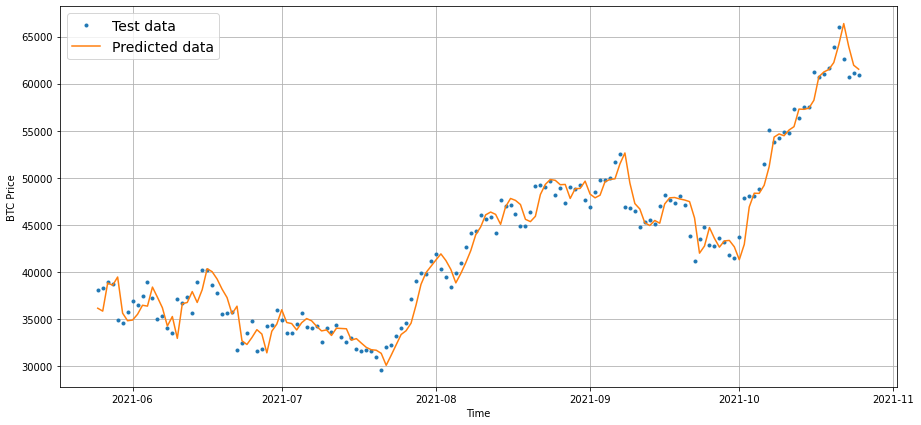

In [68]:
# Plot model 2 predictions
offset=350
plt.figure(figsize=(15,7))
plot_time_series(timesteps=X_test[-len(test_windows_30):],
                 values=test_labels_30,
                 format=".",
                 start=offset,
                 label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows_30):],
                 values=model_2_preds,
                 format="-",
                 start=offset,
                 label="Predicted data")

## Model 3: Dense (window=30, horizon=7)

In [69]:
# Setup window and horizon size
HORIZON = 7
WINDOW_SIZE = 30

In [70]:
print(f"We want windows as:{btc_price[:30]}\nHorizon:{btc_price[24:31]}")

We want windows as:[331.60083, 324.71833, 332.45666, 336.585, 346.775, 344.81166, 343.065, 358.50166, 368.07666, 376.99666, 442.10666, 389.00333, 394.92666, 377.08, 400.47166, 384.93, 375.83333, 376.16, 348.565, 352.42, 356.8, 367.83, 381.20666, 375.498, 372.819, 368.983, 375.44, 376.851, 376.13218, 377.862]
Horizon:[372.819, 368.983, 375.44, 376.851, 376.13218, 377.862, 382.452]


In [71]:
# Making windows and horizons of required shape
full_windows, full_labels = make_windows(x=prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2512, 2512)

In [72]:
# Splitting into training and testing datasets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, 
                                                                                labels=full_labels,
                                                                                test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2009, 503, 2009, 503)

In [73]:
# Set the random seed
tf.random.set_seed(42)

# Create a model
model_3 = Sequential([
  layers.Dense(128,activation="relu"),
  layers.Dense(7,activation="linear")
],name="model_3_dense")

# Compile the model
model_3.compile(
    loss=tf.keras.losses.MeanAbsoluteError(),
    optimizer=Adam(),
    metrics=["mae"]
)

# Fit the model
history_model_3 = model_3.fit(x=train_windows,y=train_labels,
                              epochs=100,verbose=1,batch_size=128,
                              validation_data=(test_windows,test_labels),
                              callbacks=[create_model_checkpoint(model_name=model_3.name)])

Epoch 1/100
16/16 [==============================] - 1s 12ms/step - loss: 2001.2130 - mae: 2001.2130 - val_loss: 4986.2900 - val_mae: 4986.2900
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 741.5358 - mae: 741.5358 - val_loss: 4453.7773 - val_mae: 4453.7773
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 585.9426 - mae: 585.9426 - val_loss: 3869.5159 - val_mae: 3869.5159
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 521.5680 - mae: 521.5680 - val_loss: 3609.8579 - val_mae: 3609.8579
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 485.6214 - mae: 485.6214 - val_loss: 3327.3459 - val_mae: 3327.3

In [74]:
# Load in the best saved model
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

16/16 [==============================] - 0s 2ms/step - loss: 2028.8264 - mae: 2028.8264


[2028.826416015625, 2028.826416015625]

In [75]:
# Make preds
model_3_preds = make_preds(model=model_3, input_data=test_windows)
model_3_preds[:5],model_3_preds.ndim

(<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
 array([[ 9760.612 ,  9864.527 ,  9930.666 ,  9927.775 ,  9807.086 ,
          9890.1455,  9968.544 ],
        [ 9886.142 ,  9939.284 ,  9833.027 ,  9978.92  ,  9905.585 ,
          9849.022 ,  9929.04  ],
        [ 9944.226 ,  9970.907 ,  9979.314 , 10021.758 ,  9910.037 ,
          9990.831 , 10008.537 ],
        [ 9668.965 ,  9848.44  ,  9713.732 ,  9653.501 ,  9624.245 ,
          9796.102 ,  9788.8955],
        [ 9554.021 ,  9722.544 ,  9713.684 ,  9543.1875,  9613.393 ,
          9742.774 ,  9812.242 ]], dtype=float32)>, 2)

In [76]:
# Restructuring the function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds (y_true,y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true,y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true,y_pred)
  rmse = mse**0.5
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred)
  mase = mean_absolute_scaled_error(y_true,y_pred)

  # Account for different sized metrics (for longer horizons, we want to reduce metrics to a single value)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae":mae.numpy(),
          "mse":mse.numpy(),
          "rmse":rmse.numpy(),
          "mape":mape.numpy(),
          "mase":mase.numpy()}

In [77]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),y_pred=model_3_preds)
model_3_results

{'mae': 2028.8263,
 'mape': 5.6735992,
 'mase': 2.1940203,
 'mse': 9911703.0,
 'rmse': 2310.1206}

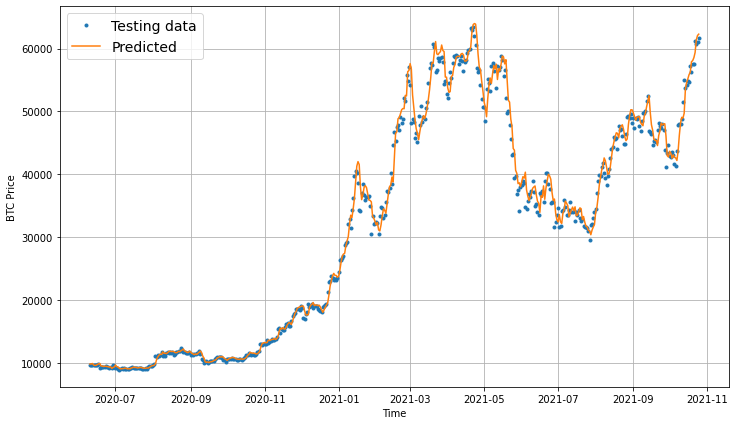

In [78]:
# Plot the model 
plt.figure(figsize=(12,7))
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:,0],
                 format=".",
                 label="Testing data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=tf.reduce_mean(model_3_preds,axis=1),
                 format="-",
                 label="Predicted")

## Which of our models is performing the best so far?

So we've trained a few models, now let's compare them and see how they've gone...

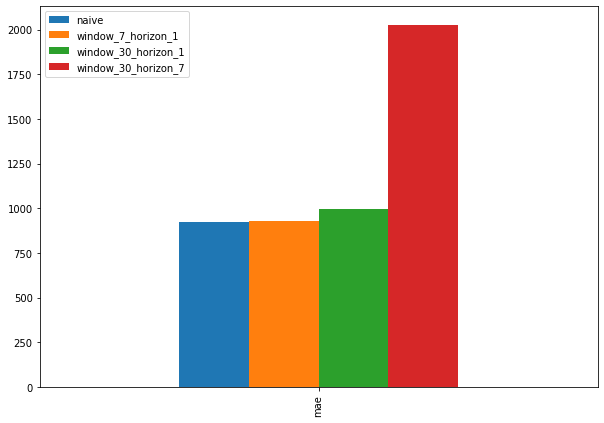

In [79]:
pd.DataFrame({"naive":naive_results["mae"],
              "window_7_horizon_1":model_1_results["mae"],
              "window_30_horizon_1":model_2_results["mae"],
              "window_30_horizon_7":model_3_results["mae"]},index=["mae"]).plot(kind="bar",figsize=(10,7));

Our naive model is performing best (it's very hard to beat a naive model in open systems) but the dense model with a horizon of 1 and a window size of 7 looks to be performing closest. 

Because of this, let's use `HORIZON=1` and `WINDOW_SIZE=7` for our next series of modelling experiments (in other words, we'll use the previous week of Bitcoin prices to try and predict the next day).

> **Note:** Why are the naive results so good? One of the reasons could be due to the presence of autocorrelation in the data. If a time series has autocorrelation, it means the value at `t+1` (the next timestep) is typically close to the value at `t` (the current timestep). In other words, today's value is probably pretty close to yesterday's value. Ofcourse, this isn't always the case but when it is, a naive model will often get fairly good results.

**Resource:** For more on how autocorrelation influence a model's predictions, see the article [How (not) to use Machine Learning for time series forecasting: Avoiding the pitfalls](https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424) by Vegard Flovik

## Model 4: Conv1D

In [80]:
HORIZON = 1 # predict next day of Bitcoin prices
WINDOW_SIZE = 7 # use previous week worth data

In [81]:
# Create window dataset
full_windows, full_labels = make_windows(x=prices,window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2541, 2541)

In [82]:
# Create splitting
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2032, 509, 2032, 509)

To use the Conv1D layer, we need an input shape of: `(batch_size,timesteps,input_dim)`...
However our data isn't in that shape yet..

In [83]:
# Check data input shape
train_windows[0].shape

(7,)

In [84]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([331.60083, 324.71833, 332.45666, 336.585  , 346.775  , 344.81166,
       343.065  ])>

In [85]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x,axis=1))

In [86]:
# Test out our lambda layer
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}")
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[331.60083]
 [324.71832]
 [332.45667]
 [336.585  ]
 [346.775  ]
 [344.81165]
 [343.065  ]]


In [87]:
 import tensorflow as tf
 # Setup random seed
 tf.random.set_seed(42)

 # Create model
 model_4 = Sequential([
  layers.Lambda(lambda x:tf.expand_dims(x,axis=1)), # converts the shape
  layers.Conv1D(128,5,1,'causal',activation='relu'),
  layers.Dense(1,activation="linear")
 ],name="model_4_Conv1D")
 
 # Compile the model
 model_4.compile(
     loss="mae",
     optimizer=Adam(),
     metrics=["mae"]
 )
 # Fit the model
 history_model_4 = model_4.fit(train_windows, train_labels,
                               epochs=100,batch_size=128,verbose=1,
                               validation_data=(test_windows,test_labels),
                               callbacks=[create_model_checkpoint(model_name=model_4.name)])

Epoch 1/100
16/16 [==============================] - 28s 20ms/step - loss: 1759.6970 - mae: 1759.6970 - val_loss: 1886.9207 - val_mae: 1886.9207
INFO:tensorflow:Assets written to: model_experiments/model_4_Conv1D/assets
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 433.3066 - mae: 433.3066 - val_loss: 2431.9797 - val_mae: 2431.9797
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 268.0899 - mae: 268.0899 - val_loss: 1606.1908 - val_mae: 1606.1908
INFO:tensorflow:Assets written to: model_experiments/model_4_Conv1D/assets
Epoch 4/100
16/16 [==============================] - 0s 6ms/step - loss: 236.2630 - mae: 236.2630 - val_loss: 1597.9762 - val_mae: 1597.9762
INFO:tensorflow:Assets written to: model_experiments/model_4_Conv1D/assets
Epoch 5/100
16/16 [==============================] - 0s 6ms/step - loss: 228.5984 - mae: 228.5984 - val_loss: 1577.2180 - val_mae: 1577.2180
INFO:tensorflow:Assets written to: model_experiments/model_4_Conv1

In [88]:
model_4.summary()

Model: "model_4_Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 1, 7)              0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1, 128)            4608      
_________________________________________________________________
dense_6 (Dense)              (None, 1, 1)              129       
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [89]:
# Evaluate model
model_4.evaluate(test_windows, test_labels)

16/16 [==============================] - 0s 4ms/step - loss: 946.5704 - mae: 946.5704


[946.5704345703125, 946.5704345703125]

In [90]:
# Load back in best performing Conv1D and re-evaluate
model_4 = tf.keras.models.load_model("model_experiments/model_4_Conv1D/")
model_4.evaluate(test_windows, test_labels)

16/16 [==============================] - 0s 3ms/step - loss: 939.1075 - mae: 939.1075


[939.1075439453125, 939.1075439453125]

In [91]:
# Make predictions 
model_4_preds = make_preds(model=model_4,input_data=test_windows)
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([9748.887, 9699.705, 9813.15 , 9743.141, 9718.38 , 9750.603,
       9829.043, 9834.075, 9901.061, 9440.918], dtype=float32)>

In [92]:
# Evaluate predictions 
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_4_preds)
model_4_results

{'mae': 939.10754,
 'mape': 2.6557553,
 'mase': 1.018497,
 'mse': 2134874.5,
 'rmse': 1461.121}

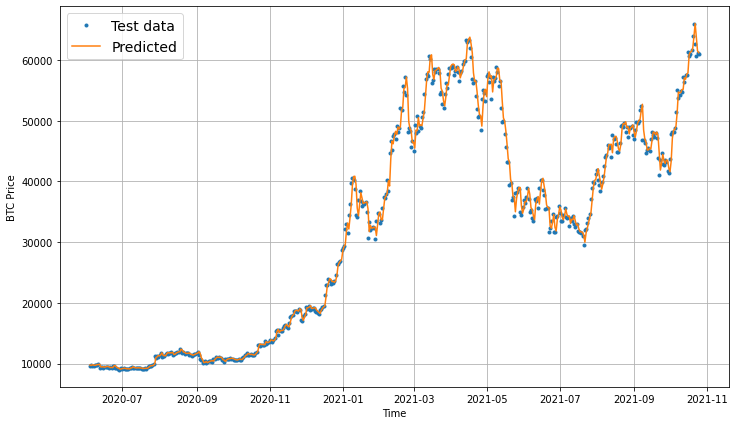

In [93]:
# Plotting model 4 predictions
plt.figure(figsize=(12,7))
plot_time_series(timesteps=X_test[1:],
                 values=test_labels[:,0],
                 format='.',
                 label="Test data")
plot_time_series(timesteps=X_test[1:],
                 values=model_4_preds,
                 format="-",
                 label="Predicted")

## Model 5: RNN (LSTM)

Let's build an RNN model for our time series data.

We'll use te same data we created previously.

In [94]:
# # Setup random seed
# tf.random.set_seed(42)

# # Create the model
# model_5 = Sequential([
#   layers.Lambda(lambda x: tf.expand_dims(x,axis=1)),
#   layers.LSTM(128,activation="relu"),
#   layers.Dense(1)
# ],name="model_5_LSTM")

# # Compile the model
# model_5.compile(
#     loss="mae",
#     optimizer=Adam()
# )

# # Fit the model
# history_model_5 = model_5.fit(train_windows, train_labels,
#                               epochs=100,verbose=1,batch_size=128,
#                               validation_data=(test_windows,test_labels),
#                               callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [95]:
# Setup random seed
tf.random.set_seed(42)

# Create the model using Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x,axis=1))(inputs)
x = layers.LSTM(128,activation="relu")(x)
outputs = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=outputs,name="model_5_LSTM")

# Compile the model
model_5.compile(
    loss="mae",
    optimizer=Adam(),
    metrics=["mae"]
)

# Fit the model
history_model_5 = model_5.fit(train_windows,
                              train_labels,
                              epochs=100,verbose=1,batch_size=128,
                              validation_data=(test_windows,test_labels),
                              callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
16/16 [==============================] - 2s 26ms/step - loss: 3224.6982 - mae: 3224.6982 - val_loss: 18597.9531 - val_mae: 18597.9531
INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 1488.3822 - mae: 1488.3822 - val_loss: 4403.3438 - val_mae: 4403.3438
INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 375.0297 - mae: 375.0297 - val_loss: 2266.3738 - val_mae: 2266.3738
INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 261.3912 - mae: 261.3912 - val_loss: 1836.7257 - val_mae: 1836.7257
INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 230.8783 - mae: 230.8783 - val_loss: 1605.2917 - val_mae: 1605.

In [96]:
# Evaluate the model
model_5 = tf.keras.models.load_model("model_experiments/model_5_LSTM")
model_5.evaluate(test_windows,test_labels)

16/16 [==============================] - 0s 3ms/step - loss: 984.5150 - mae: 984.5150


[984.5149536132812, 984.5149536132812]

In [97]:
# Make predictions
model_5_preds = make_preds(model=model_5, input_data=test_windows)
model_5_preds[:10],model_5_preds.ndim

(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([9812.398 , 9713.13  , 9784.382 , 9797.392 , 9652.1045, 9763.012 ,
        9817.264 , 9814.001 , 9888.116 , 9524.883 ], dtype=float32)>, 1)

In [98]:
# Model 5 Results
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_5_preds)
model_5_results

{'mae': 984.5149,
 'mape': 2.7913442,
 'mase': 1.067743,
 'mse': 2287168.8,
 'rmse': 1512.3389}

Because neural networks are such powerful algorithms, they can be used for almost any problem, however, that doesn't mean they'll achieve performant or usable results.

## Model 6: Dense model with Multi-variate data

### Make a multi-variate time series dataset

Before we add a feature to our time series, what is a feature we can use?

One feature we could add is whether or not Elon Musk tweeted on that day...

* day 1 - 0
* day 2 - 1
* day 3 - 0

What's a better feature to use?

How about the Bitcoin Halving events?
https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving

In [99]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2014-11-03,331.60083
2014-11-04,324.71833
2014-11-05,332.45666
2014-11-06,336.58500
2014-11-07,346.77500


In [100]:
# Let's add the bitcoin halving events to our dataset
block_reward_1 = 50 # 3 January 2009 - this block reward isn't in our dataset (our data starts from 03 November 2014)
block_reward_2 = 25 # 28 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [102]:
bitcoin_prices.index[0]

Timestamp('2014-11-03 00:00:00')

In [103]:
# Create date ranges of where specific block reward values should be
block_reward_2_ndays = (block_reward_3_datetime-bitcoin_prices.index[0]).days
block_reward_3_ndays = (block_reward_4_datetime-bitcoin_prices.index[0]).days
block_reward_2_ndays, block_reward_3_ndays

(614, 2023)

In [104]:
# Add in a block reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Add in block reward values as a feature to our dataframe
bitcoin_prices_block.iloc[:block_reward_2_ndays,-1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_ndays:block_reward_3_ndays,-1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_ndays:,-1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2014-11-03,331.60083,25
2014-11-04,324.71833,25
2014-11-05,332.45666,25
2014-11-06,336.58500,25
2014-11-07,346.77500,25


In [105]:
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2021-10-21,65972.863130,6.25
2021-10-22,62603.575070,6.25
2021-10-23,60689.238265,6.25
2021-10-24,61124.347126,6.25
2021-10-25,60936.150851,6.25


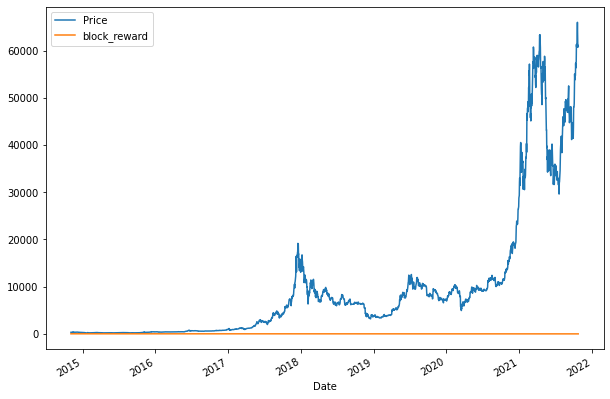

In [106]:
bitcoin_prices_block.plot(figsize=(10,7));

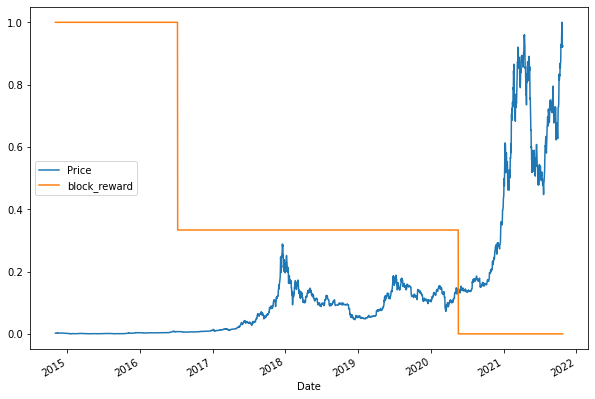

In [107]:
# Plot the block reward vs price over time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price","block_reward"]]),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10,7));

## Making a windowed dataset with pandas

Previously, we've turned our univariate time series into windowed dataset using the helper functions above.

However, since we've got multivariate data, these functions won't work.

Not to worry, we can use the pandas.DataFrame.shift() methid to window our multivariate data.

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift,html

In [108]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [114]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns 
for i in range(WINDOW_SIZE):   # shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2014-11-03,331.60083,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-04,324.71833,25,331.60083,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-05,332.45666,25,324.71833,331.60083,NaN,NaN,NaN,NaN,NaN
2014-11-06,336.58500,25,332.45666,324.71833,331.60083,NaN,NaN,NaN,NaN
2014-11-07,346.77500,25,336.58500,332.45666,324.71833,331.60083,NaN,NaN,NaN
2014-11-08,344.81166,25,346.77500,336.58500,332.45666,324.71833,331.60083,NaN,NaN
2014-11-09,343.06500,25,344.81166,346.77500,336.58500,332.45666,324.71833,331.60083,NaN
2014-11-10,358.50166,25,343.06500,344.81166,346.77500,336.58500,332.45666,324.71833,331.60083
2014-11-11,368.07666,25,358.50166,343.06500,344.81166,346.77500,336.58500,332.45666,324.71833


What we've done is created a way to window our dataset directly from a pandas dataframe.

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

In [115]:
# Create X (windows) and y (horizons) features
X = bitcoin_prices_windowed.dropna().drop("Price",axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-11-10,25.0,343.065002,344.811646,346.774994,336.584991,332.456665,324.718323,331.600830
2014-11-11,25.0,358.501648,343.065002,344.811646,346.774994,336.584991,332.456665,324.718323
2014-11-12,25.0,368.076660,358.501648,343.065002,344.811646,346.774994,336.584991,332.456665
2014-11-13,25.0,376.996674,368.076660,358.501648,343.065002,344.811646,346.774994,336.584991
2014-11-14,25.0,442.106659,376.996674,368.076660,358.501648,343.065002,344.811646,346.774994


In [116]:
y.head()

Date
2014-11-10    358.501648
2014-11-11    368.076660
2014-11-12    376.996674
2014-11-13    442.106659
2014-11-14    389.003326
Name: Price, dtype: float32

In [117]:
# Make train & test sets using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2032, 2032, 509, 509)

## Model 6: Dense (multivariate time series)

In [118]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
],name="model_6_dense_multivariate")

# Compile the model
model_6.compile(
    loss = "mae",
    optimizer = Adam())

# Fit the model
history_model_6 = model_6.fit(X_train, y_train,
                              epochs=100, batch_size=128, verbose=1,
                              validation_data=(X_test,y_test),
                              callbacks=[create_model_checkpoint(model_name=model_6.name)])

Epoch 1/100
16/16 [==============================] - 1s 12ms/step - loss: 1777.7953 - val_loss: 1997.5948
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 452.8227 - val_loss: 2448.9355
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 297.3582 - val_loss: 1818.4749
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 260.3947 - val_loss: 1777.9661
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 251.5067 - val_loss: 1756.9111
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 245.1339 - val_loss: 1744.1013
INFO:tensorflow:Assets wri

In [119]:
# Evaluate multivariate model
model_6.evaluate(X_test,y_test)

16/16 [==============================] - 0s 2ms/step - loss: 940.5834


940.5833740234375

In [120]:
# Load in and evaluate best performing model
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

16/16 [==============================] - 0s 2ms/step - loss: 923.3631


923.3630981445312

In [122]:
# Make predictions with multivariate model
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([9700.47 , 9637.926, 9823.731, 9712.924, 9674.768, 9767.268,
       9807.052, 9811.905, 9890.185, 9387.654], dtype=float32)>

In [124]:
# Evaluate predictions to get eval metrics
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 923.363,
 'mape': 2.6101313,
 'mase': 1.0014215,
 'mse': 2078720.0,
 'rmse': 1441.7767}